In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def convolve_kernels(distribution_kernels, dx):
    """
    distribution_kernels: list of kernels 
    """
    for i, distribution in enumerate(distribution_kernels):
        if i == 0:
            convolution = np.convolve(distribution, distribution_kernels[1], mode='same') * dx
        if i != 0 and i < len(distribution_kernels): 
            convolution = np.convolve(convolution, distribution, mode='same') * dx
    return convolution

In [3]:
def delta_kernel_1d(x0, intint, x, dx):
    # Normalized Delta function
    y = np.zeros_like(x)  # Empty array
    temp = np.argmin(np.abs(x - x0))  # Find the closest point
    y[temp] = 1
    y = intint * y / (np.sum(y) * dx)
    return y

def tophat_kernel_1d(x0, halfwidth, intint, x, dx):
    # Normalized Tophat function
    y = np.zeros_like(x)  # Empty array
    temp = np.where((x >= x0 - halfwidth) & (x <= x0 + halfwidth))
    y[temp] = 1
    y = intint * y / (np.sum(y) * dx)
    return y

def triangle_kernel_1d(x0, basehalfwidth, intint, x, dx):
    # Normalized Triangle function
    y = np.zeros_like(x)  # Empty array
    temp = np.where((x >= x0 - basehalfwidth) & (x <= x0 + basehalfwidth))
    y[temp] = 1 - (1 / basehalfwidth) * np.abs(x[temp] - x0)
    y = intint * y / (np.sum(y) * dx)
    return y

def circle_kernel_1d(x0, radius, intint, x, dx):
    # Normalized Tophat function
    y = np.zeros_like(x)  # Empty array
    temp = np.where((x >= (x0 - radius)) & (x <= (x0 + radius)))
    y[temp] = np.sqrt(radius**2 - (x[temp] - x0)**2)
    y = intint * y / (np.sum(y) * dx)
    return y

In [7]:
x0 = 0.0
intint = 1.0
x_values = np.linspace(-10, 10, 1000)
dx = x[1] - x[0]

delta_distribution = delta_kernel_1d(x0, intint, x_values, dx)

halfwidth = 2.0
geometric_divergence = tophat_kernel_1d(x0, halfwidth, intint, x_values, dx)

halfwidth = 1.0
sample_aperture_smearing = tophat_kernel_1d(x0, halfwidth, intint, x_values, dx)

basehalfwidth = 1.0
detector_pixelation = triangle_kernel_1d(x0, basehalfwidth, intint, x_values, dx)

radius = 2.0
binning_resolution = circle_kernel_1d(x0, radius, intint, x_values, dx)

#distribution_kernels = [geometric_divergence, sample_aperture_smearing, detector_pixelation, binning_resolution, wavelength_resolution]

distribution_kernels = [geometric_divergence, sample_aperture_smearing, detector_pixelation, binning_resolution]

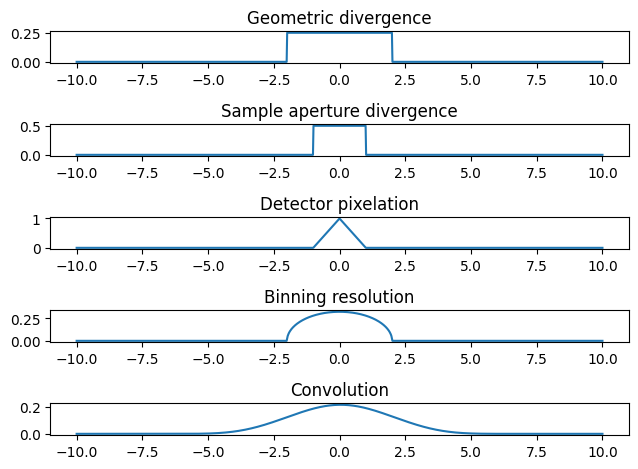

In [8]:
convolution = convolve_kernels(distribution_kernels, dx)

plt.subplot(5, 1, 1)
plt.plot(x_values, geometric_divergence)
plt.title('Geometric divergence')

plt.subplot(5, 1, 2)
plt.plot(x_values, sample_aperture_smearing)
plt.title('Sample aperture divergence')


plt.subplot(5, 1, 3)
plt.plot(x_values, detector_pixelation)
plt.title('Detector pixelation')

plt.subplot(5, 1, 4)
plt.plot(x_values, binning_resolution)
plt.title('Binning resolution')

plt.subplot(5, 1, 5)
plt.plot(x_values, convolution)
plt.title('Convolution')
plt.tight_layout()


#convolution = np.convolve(top_hat(x_values, a_top, b_top, c_top), triangular_distribution(x_values, a_tri, b_tri, c_tri), mode='same') * (x_values[1] - x_values[0])
plt.show()
